In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [42]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [44]:
fracs_mnum = 3200
seeds_mnum = 320

In [218]:
both_res = parse_results('grid_search_results/subsets_both_5-seeds_20.txt')
frac1 = both_res[fracs_mnum*0:fracs_mnum*1]
frac2 = both_res[fracs_mnum*1:fracs_mnum*2]
frac3 = both_res[fracs_mnum*2:fracs_mnum*3]
frac4 = both_res[fracs_mnum*3:fracs_mnum*4]
frac6 = both_res[fracs_mnum*4:fracs_mnum*5]
frac8 = both_res[fracs_mnum*5:fracs_mnum*6]
# hyp_res = both_res[:len(both_res)//2]
# euc_res = both_res[len(both_res)//2:]
# hyp_res = both_res
# euc_res = both_res
frac = frac8
hyp_res = frac
euc_res = frac

In [219]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

# fix for fracs with multiple seeds
hyp_params = hyp_params[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]
hyp_values = hyp_values[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]

euc_params = euc_params[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]
euc_values = euc_values[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]

hyp_values.shape, euc_values.shape

((1600, 5, 20), (1600, 5, 20))

In [220]:
hyp_params = hyp_params.reshape([5,seeds_mnum])[0]
hyp_values = hyp_values.reshape([5,seeds_mnum,5,20]).mean(axis=0)

euc_params = euc_params.reshape([5,seeds_mnum])[0]
euc_values = euc_values.reshape([5,seeds_mnum,5,20]).mean(axis=0)

hyp_values.shape, euc_values.shape

((320, 5, 20), (320, 5, 20))

In [221]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [222]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[1, 2, 4, 8]
[2, 8, 16, 64, 128]
[0.01, 0.02, 0.03, 0.04]
[0.01, 0.02, 0.03, 0.04]


In [223]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [224]:
hyp_values[0::len(WD)].mean(axis=1)[:,-1].reshape(-1,len(LR))[:,0].shape

(20,)

In [225]:
num_hidden_layers.shape, layer_size.shape

((20,), (20,))

--------------- Weight Decay: 0.01 ---------------


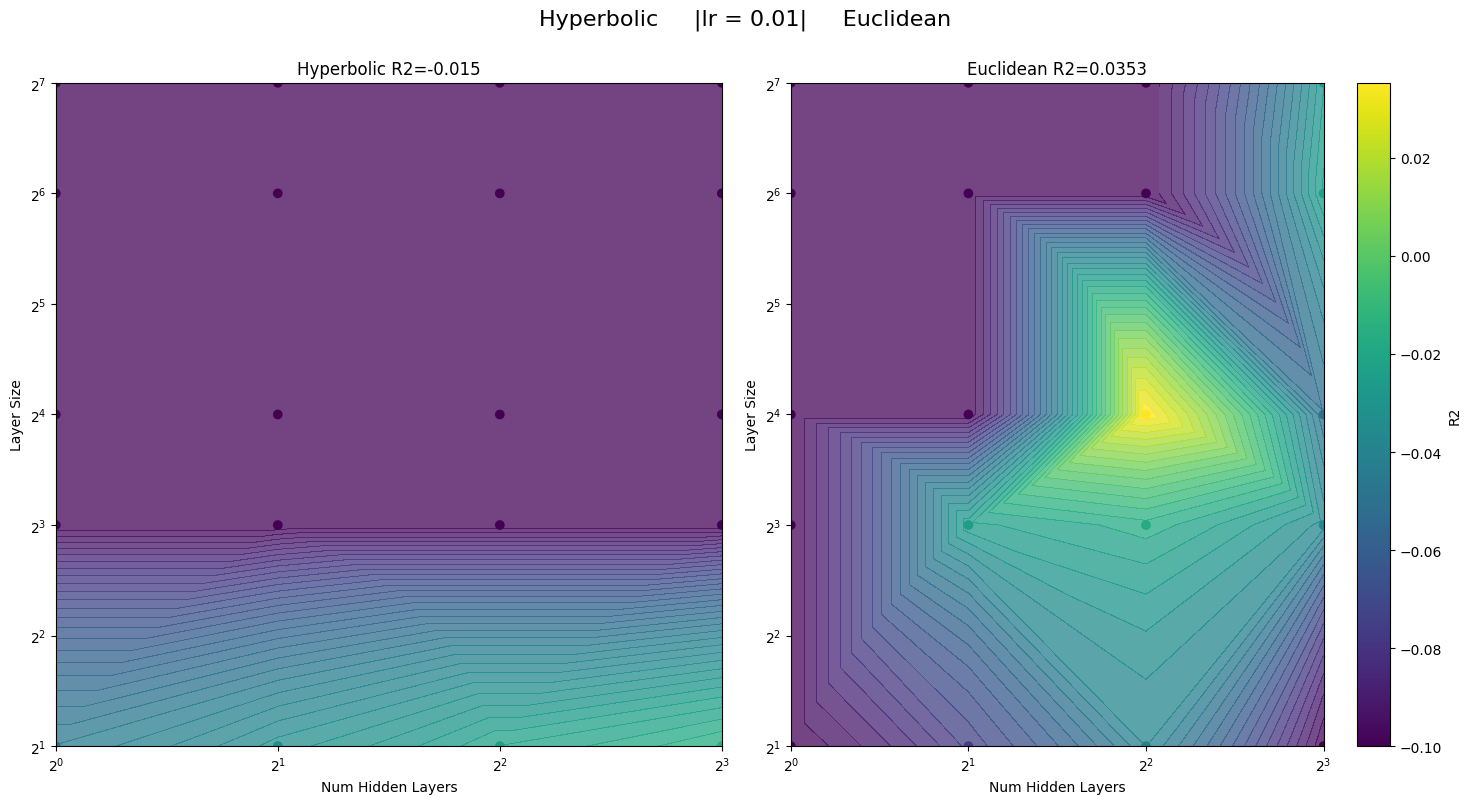

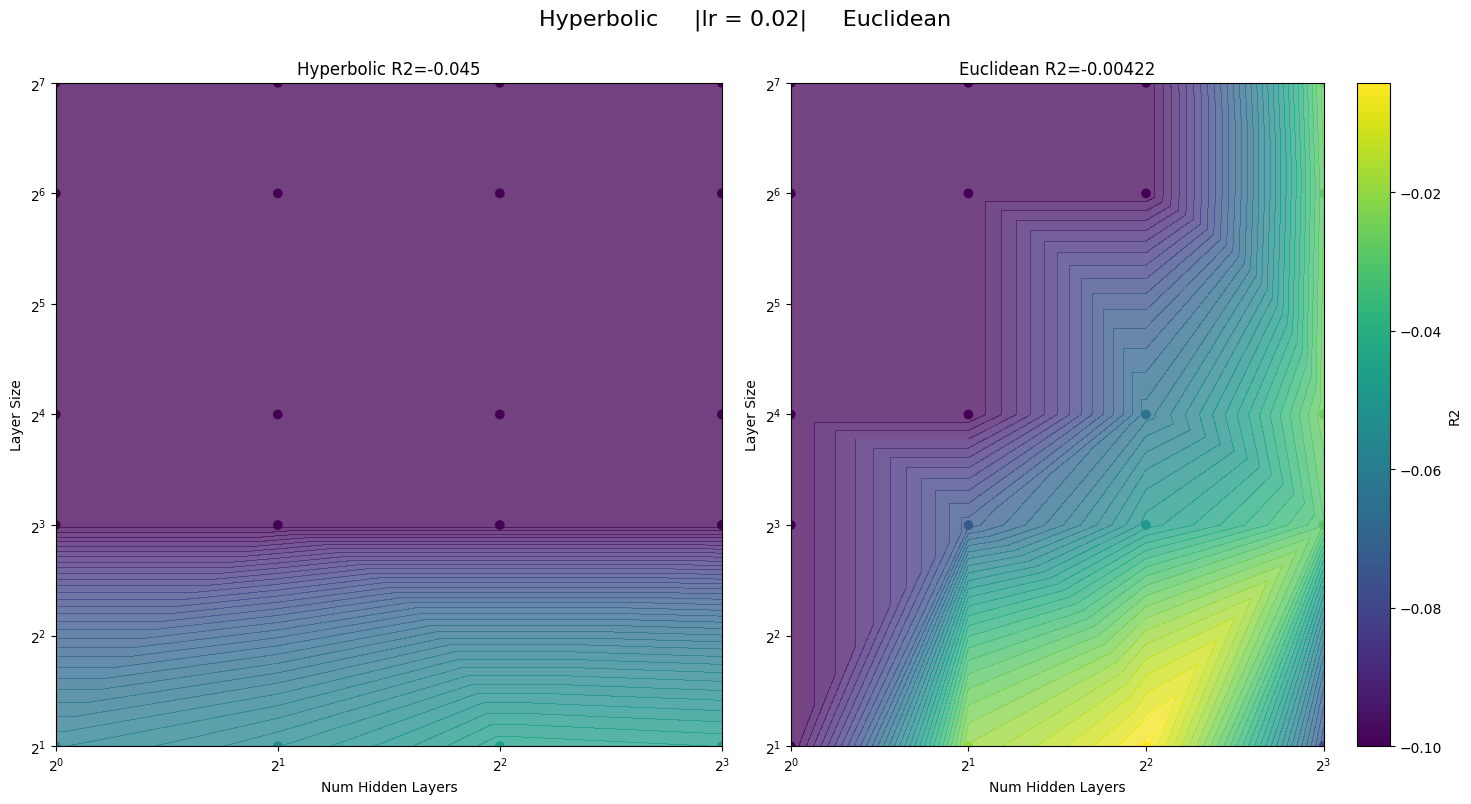

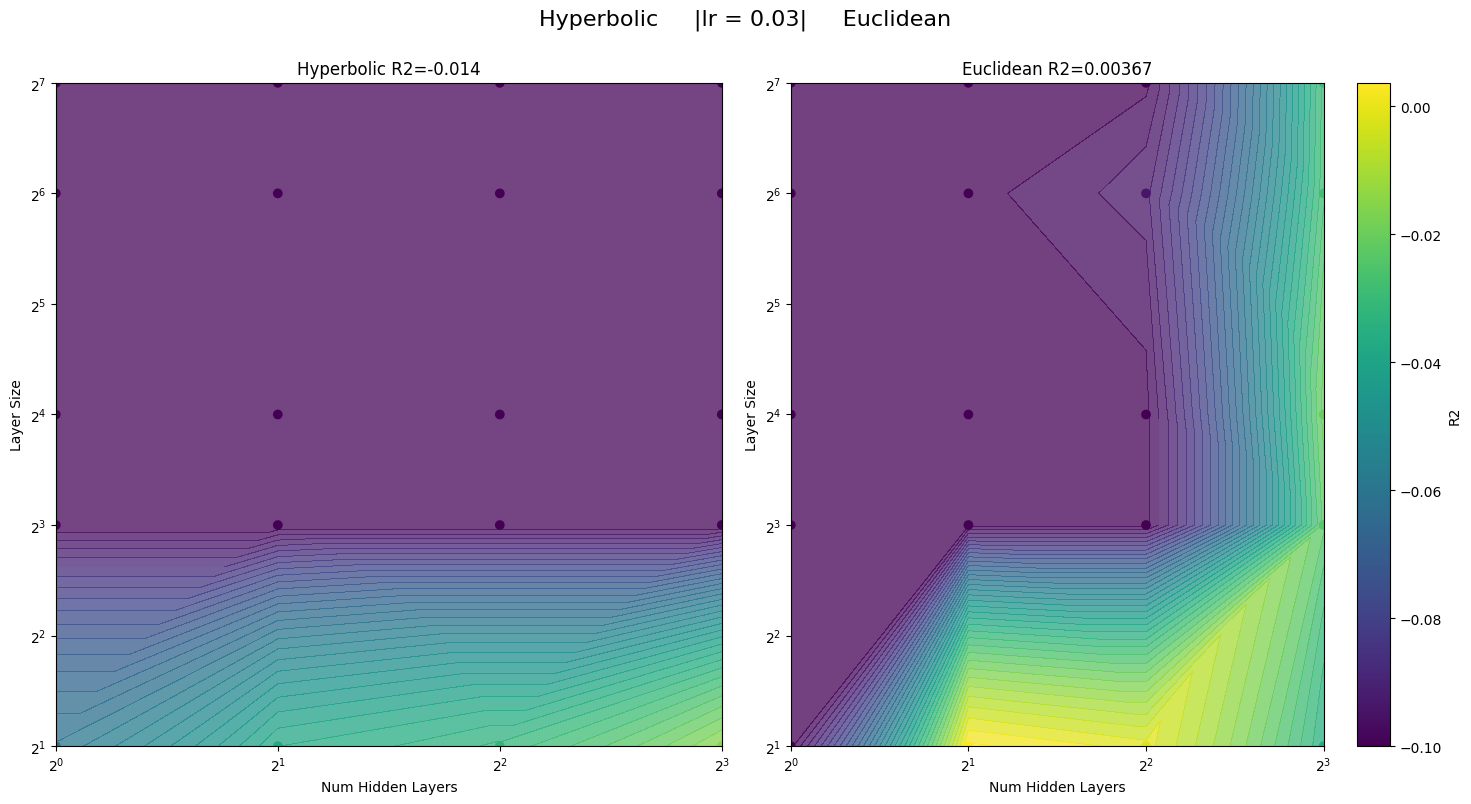

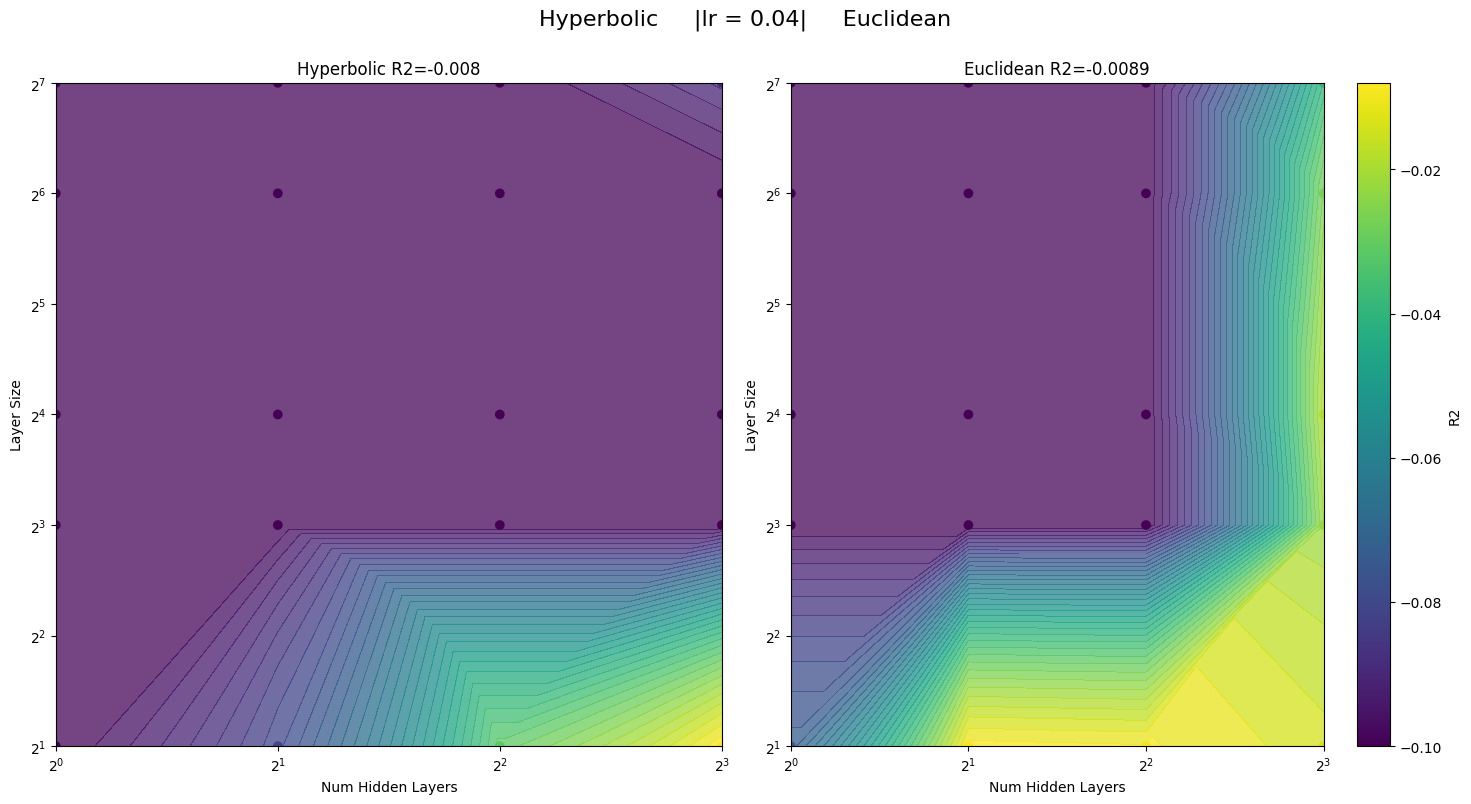

--------------- Weight Decay: 0.02 ---------------


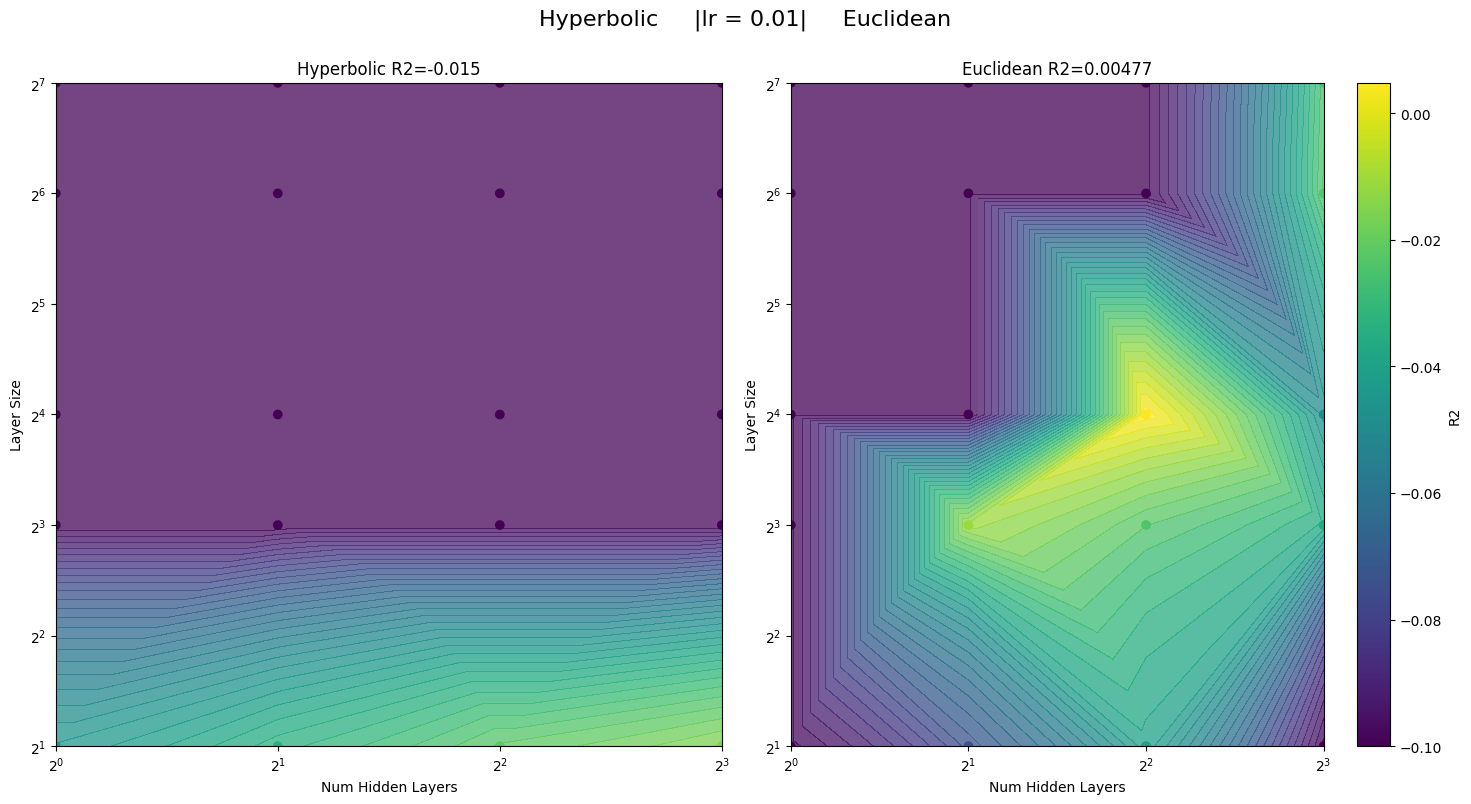

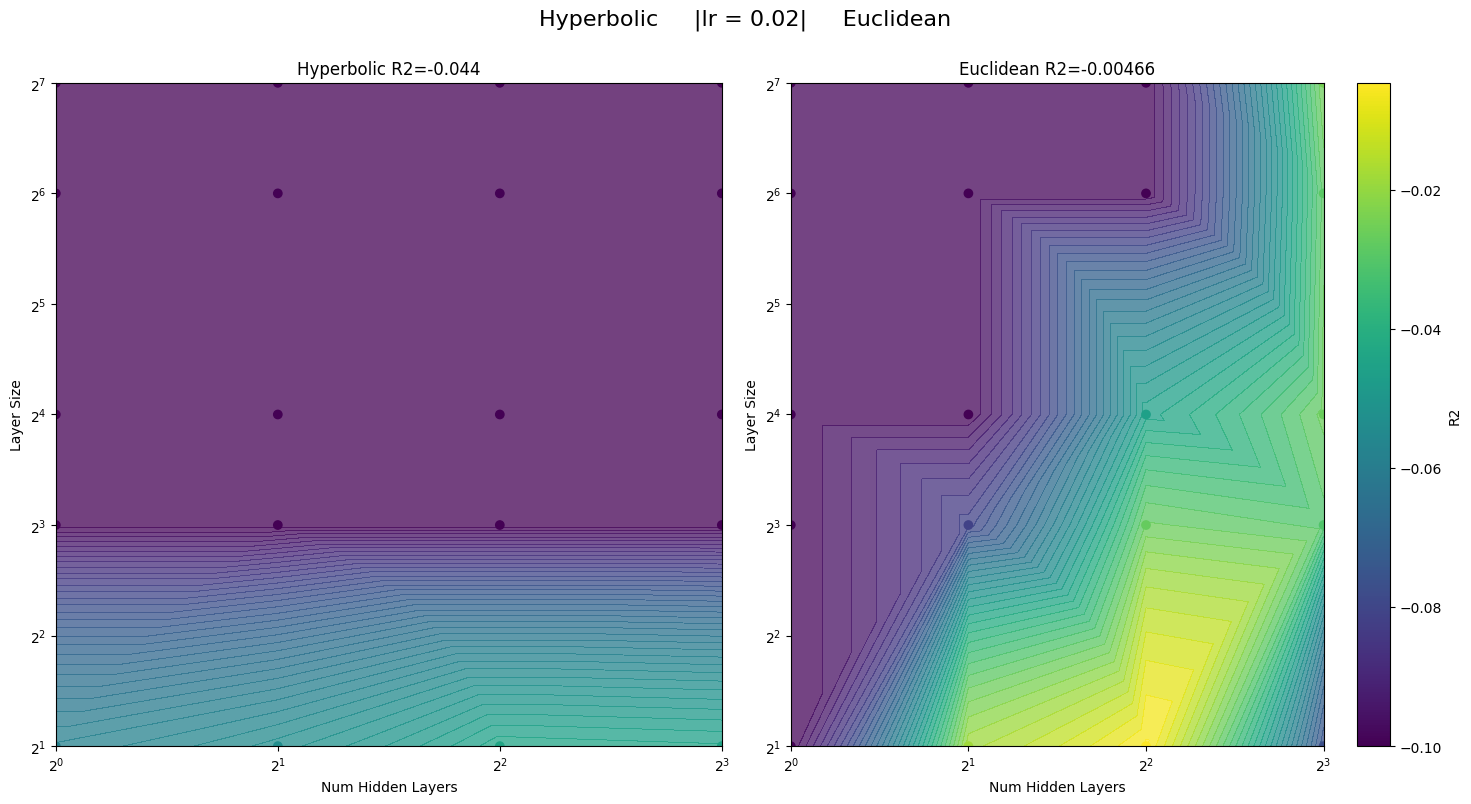

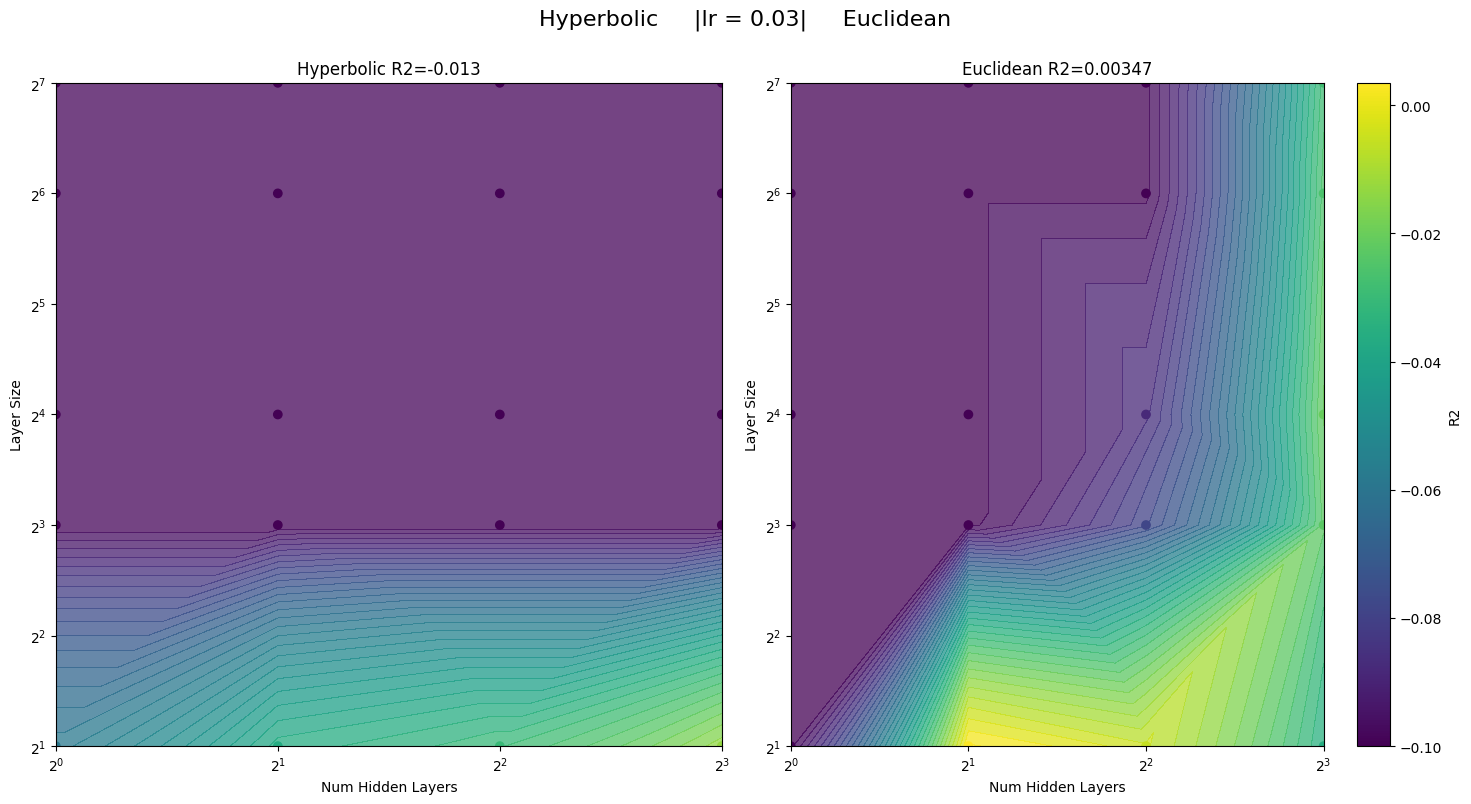

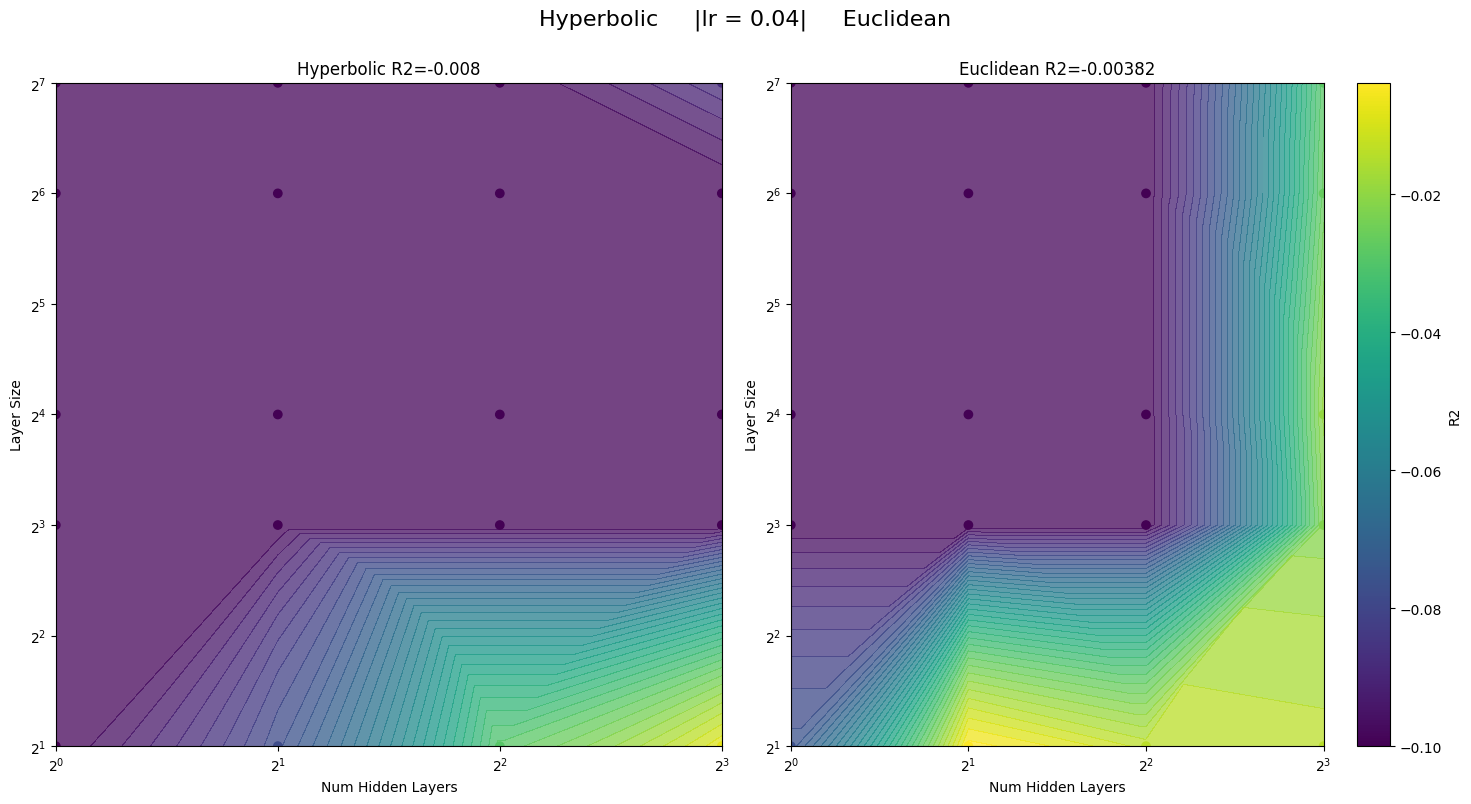

--------------- Weight Decay: 0.03 ---------------


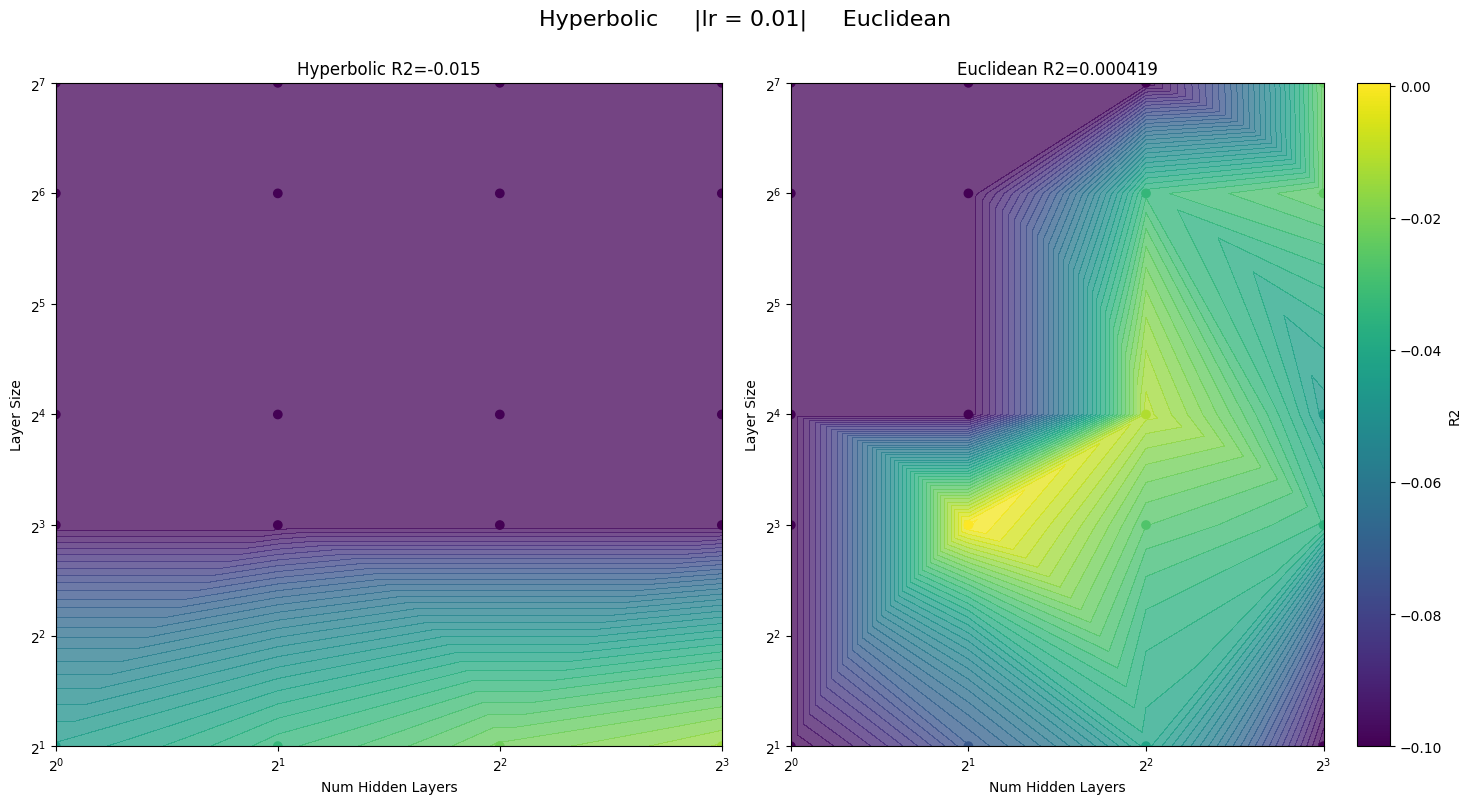

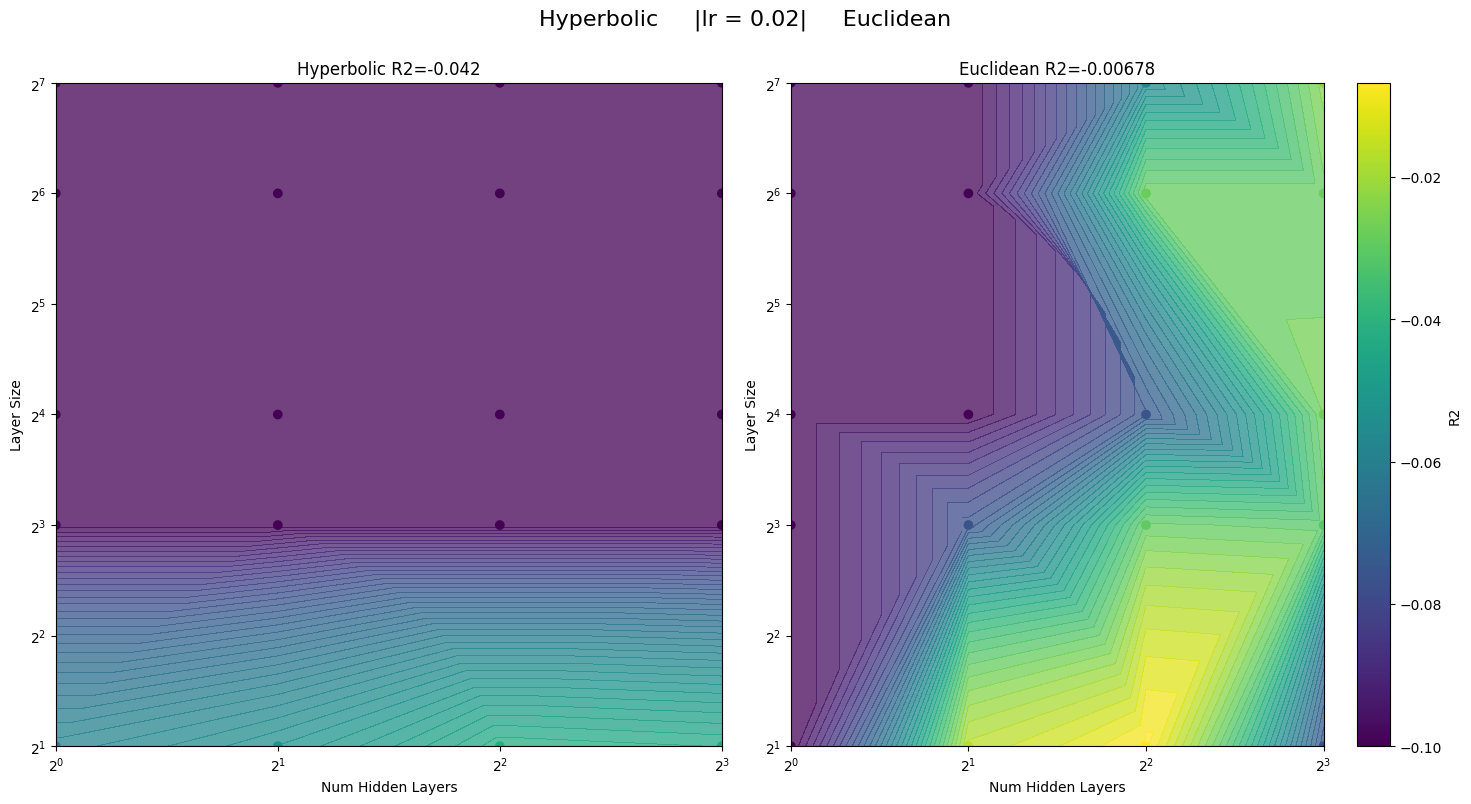

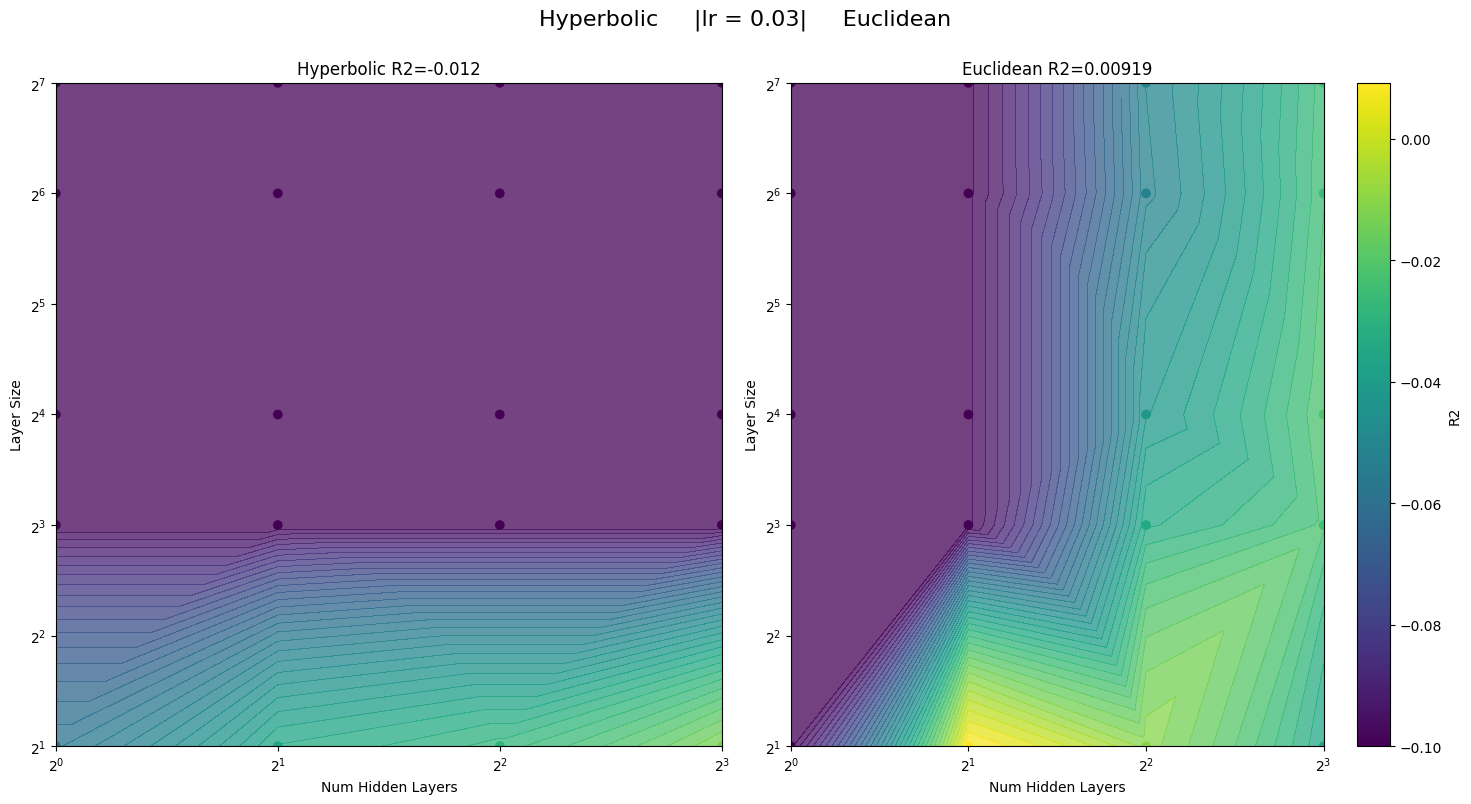

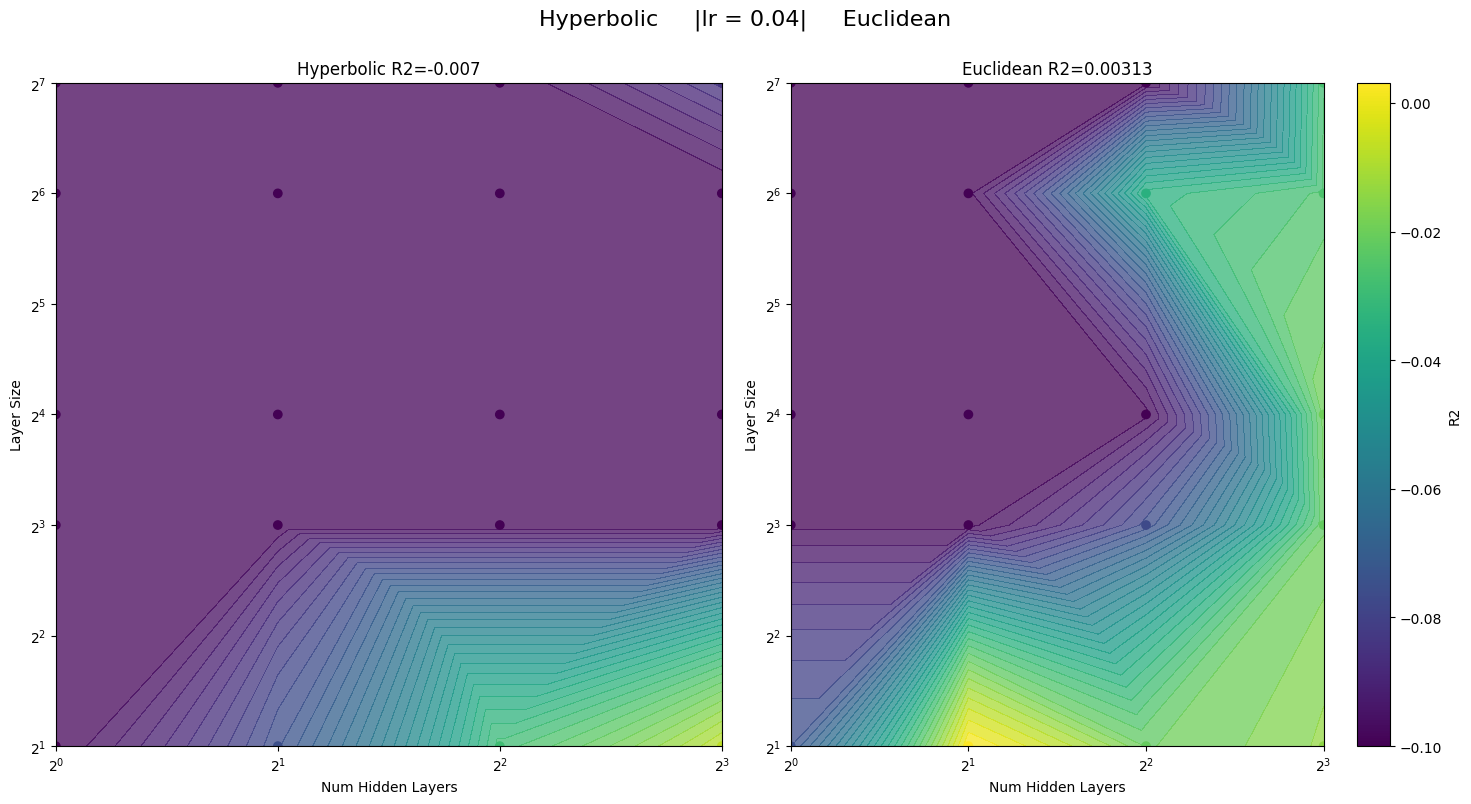

--------------- Weight Decay: 0.04 ---------------


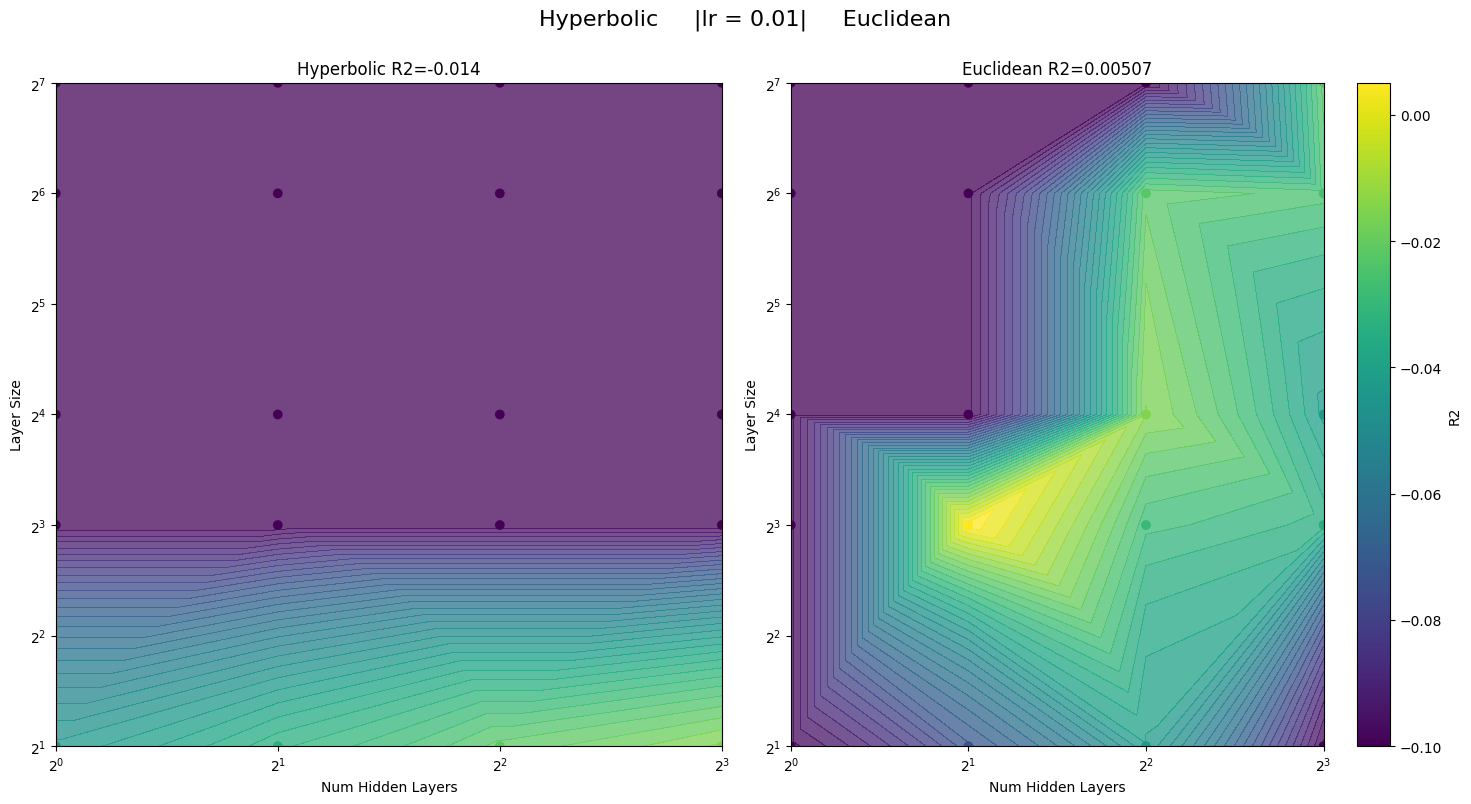

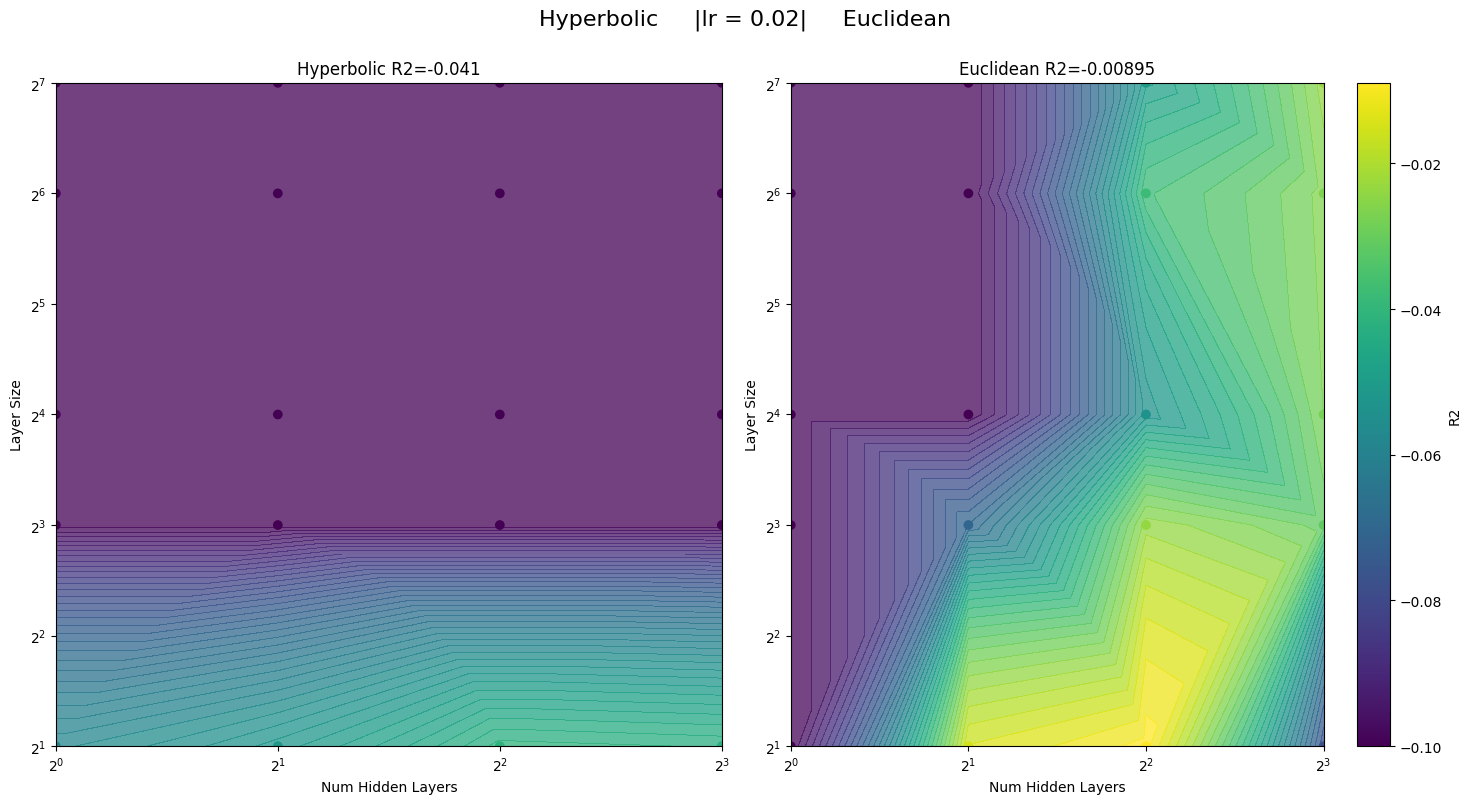

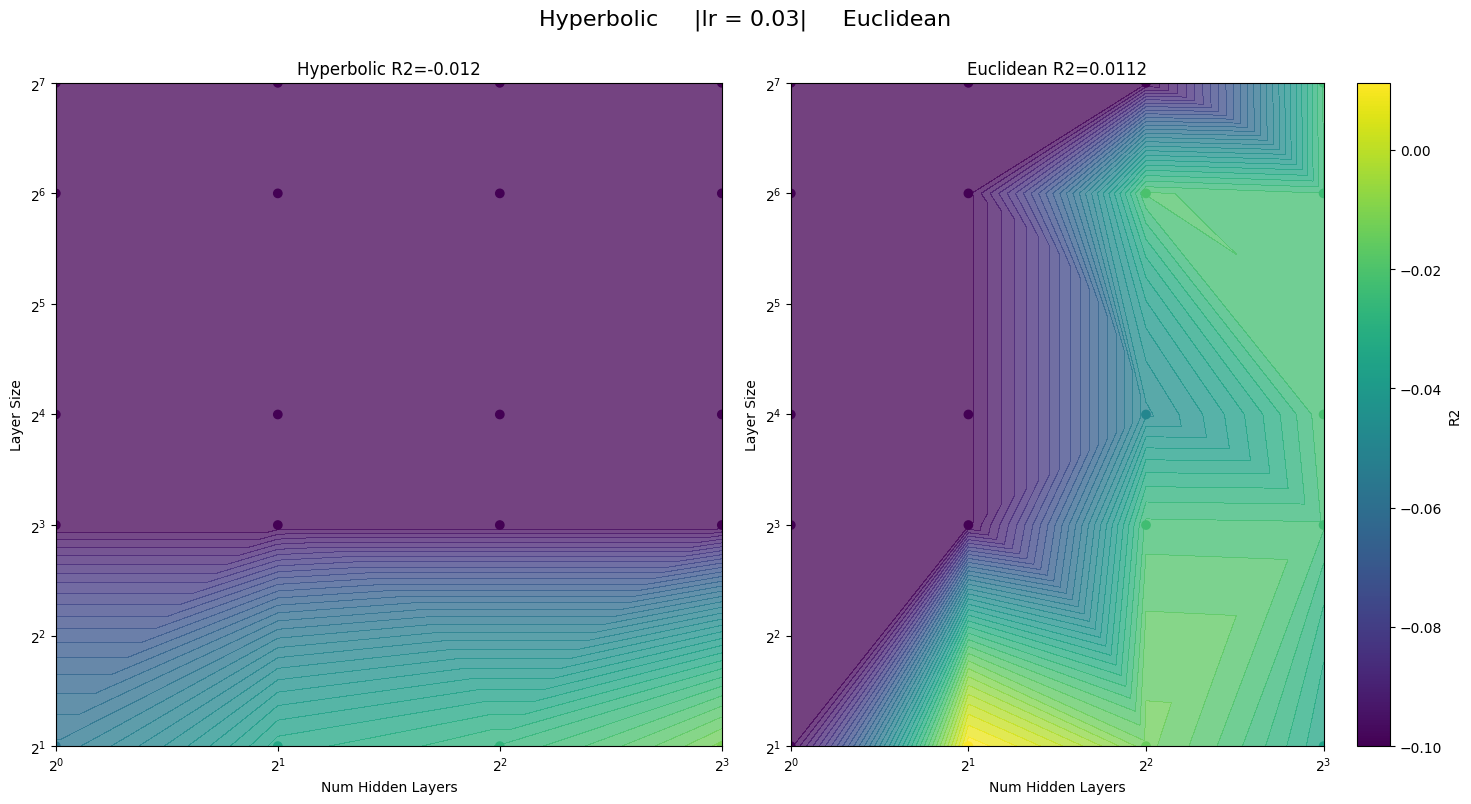

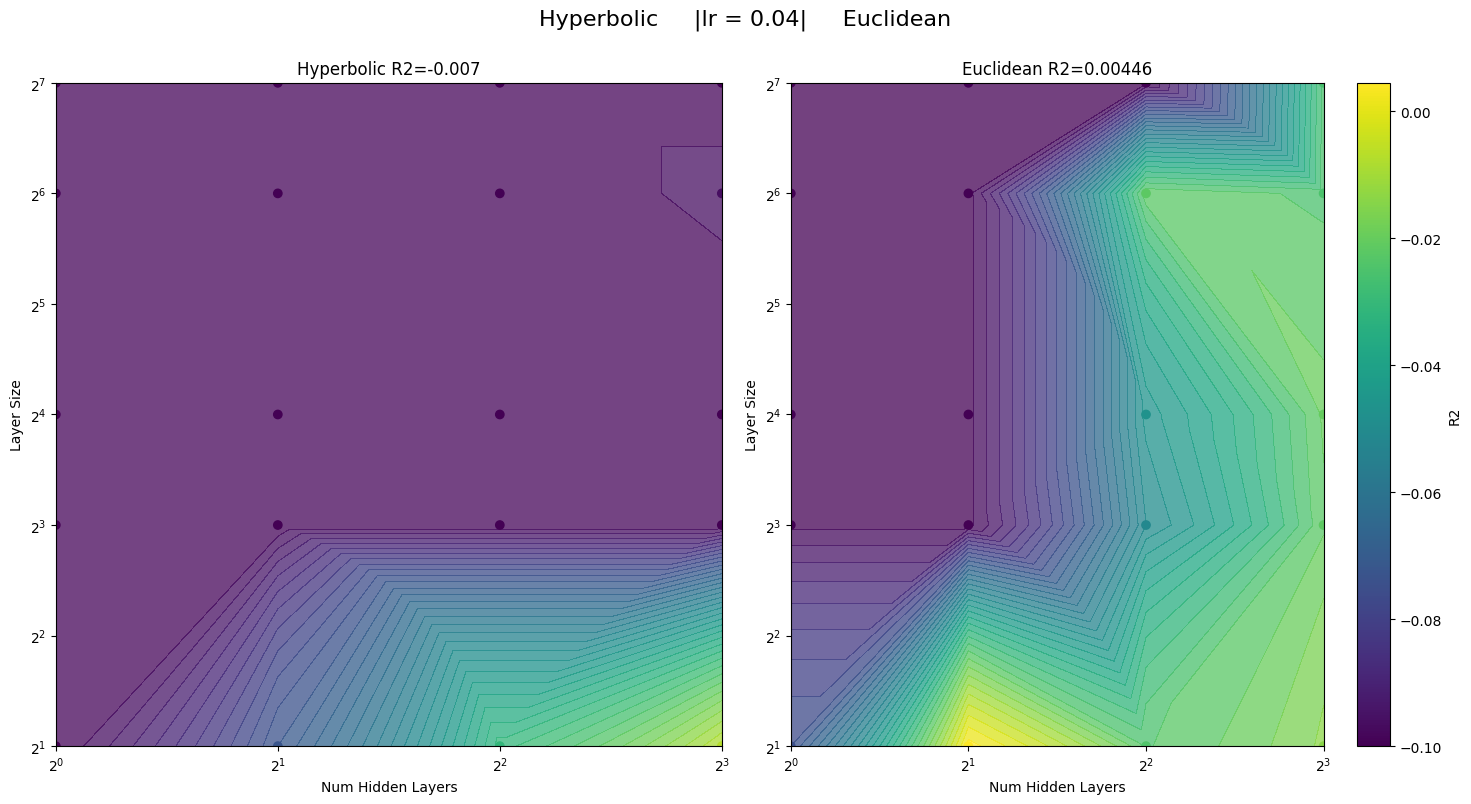

In [131]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_values[i::len(WD)]
    euc_values_wd = euc_values[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = hyp_values_wd.mean(axis=1)[:,9].reshape(-1,len(LR))[:,i].clip(-0.1)
        euc_data = euc_values_wd.mean(axis=1)[:,9].reshape(-1,len(LR))[:,i].clip(-0.1)

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic R2={np.max(hyp_data):.3f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='R2')


        plt.title(f'Euclidean R2={np.max(euc_data):.3}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

<h3>ALL</h3>

- Hyp: 0.116
- Euc: 0.185

<h3>BOTH</h3>

- Hyp: 0.120
- Euc: 0.139

<h3>AROMA</h3>

- Hyp: 0.099
- Euc: 0.100

<h3>FLAVOUR</h3>

- Hyp: 0.157
- Euc: 0.159

<h3>overall</h3>

- Hyp: 0.057
- Euc: 0.105


<h2>Take subsets of normal cross-val train-indices, average over 5 seeds</h2>
<!-- <h3>Hyp take epoch [1], Euc take epoch [4].</h3> -->
 
<h3>1</h3>

- Hyp: 0.066; 8,16; 0.03,0.004 (1)
- Euc: 0.124; 2,2; 0.02,0.002 (4)

<h3>1/2</h3>

- Hyp: 0.048; 1,128; 0.01,0.004 (0)
- Euc: 0.066; 1,64; 0.01,0.005 (1)

<h3>1/3</h3>

- Hyp: 0.035; 2,64; 0.01,0.001 (0)
- Euc: 0.050; 1,16; 0.01,0.001 (1)

<h3>1/4</h3>

- Hyp: 0.022; 1,128; 0.01,0.004 (0)
- Euc: 0.050, 1,16; 0.01,0.004 (2)

<h3>1/6</h3>

- Hyp: 0.009; 1,128; 0.01,0.004 (0)
- Euc: 0.023; 4,16; 0.02,0.01 (4)

<h3>1/8</h3>

- Hyp: 0.000; 1,128; 0.01,0.004 (0)
- Euc: 0.020; 4,16; 0.02,0.001 (4)

In [252]:
K = 4

best_hyp_params = list(reversed(np.argsort(hyp_values.mean(axis=1)[:,K])[-9:]))
print(hyp_values.mean(axis=1)[:,K][best_hyp_params])
print()
best_euc_params = list(reversed(np.argsort(euc_values.mean(axis=1)[:,K])[-9:]))
print(euc_values.mean(axis=1)[:,K][best_euc_params])

best_hyp_runs = hyp_values.mean(axis=1)[best_hyp_params]
best_euc_runs = euc_values.mean(axis=1)[best_euc_params]

[-0.0605265  -0.06102853 -0.06230774 -0.06506427 -0.06733461 -0.06931797
 -0.07276151 -0.07301087 -0.0742102 ]

[ 0.01982586  0.00222865 -0.00107199 -0.00375368 -0.00384746 -0.00409906
 -0.00475381 -0.0117958  -0.01323959]


In [251]:
print(hyp_params[best_hyp_params])
print()
print(euc_params[best_euc_params])

[{'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 64, 'lr': 0.04, 'weight_decay': 0.03, 'batch_size': 1024, 'epochs': 20, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 64, 'lr': 0.04, 'weight_decay': 0.04, 'batch_size': 1024, 'epochs': 20, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 64, 'lr': 0.04, 'weight_decay': 0.02, 'batch_size': 1024, 'epochs': 20, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 64, 'lr': 0.04, 'weight_decay': 0.01, 'batch_size': 1024, 'epochs': 20, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 2, 'lr': 0.02, 'weight_decay': 0.04, 'batch_size': 1024, 'epochs': 20, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_ty

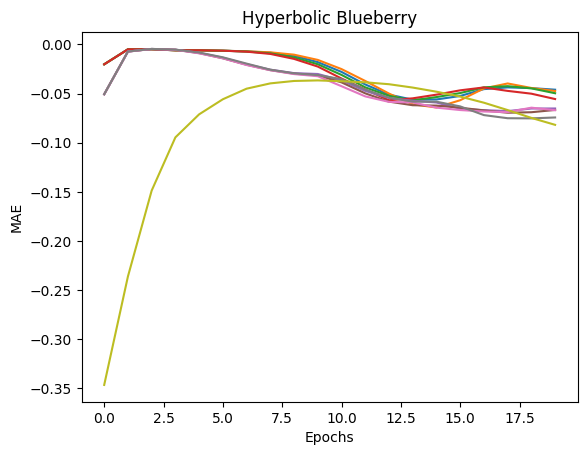

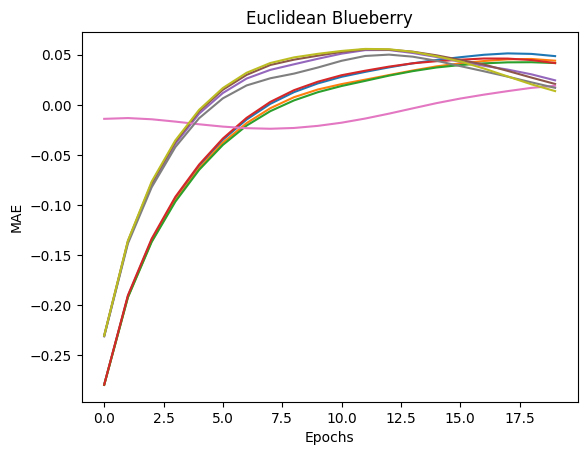

In [162]:
for run in hyp_values.mean(axis=1)[best_hyp_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Blueberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

# plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()

for run in euc_values.mean(axis=1)[best_euc_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Blueberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

# plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()


In [14]:
print(np.mean(hyp_values.mean(axis=1)[:,9]))
print(np.mean(hyp_values.mean(axis=1)[:,14]))
print(np.mean(hyp_values.mean(axis=1)[:,19]))
print(np.mean(hyp_values.mean(axis=1)[:,29]))
print(np.mean(hyp_values.mean(axis=1)[:,39]))
print()
print(np.mean(euc_values.mean(axis=1)[:,9]))
print(np.mean(euc_values.mean(axis=1)[:,14]))
print(np.mean(euc_values.mean(axis=1)[:,19]))
print(np.mean(euc_values.mean(axis=1)[:,29]))
print(np.mean(euc_values.mean(axis=1)[:,39]))
print()
print(hyp_values.mean(axis=1).max(axis=0).argmax())
print(euc_values.mean(axis=1).max(axis=0).argmax())

-0.21000808758068115
-0.25556601363255127
-0.29093834765934334
-0.3215709097797275
-0.34549831543386894

-3943828355988433.5
-1146138196092319.5
-1456940835880565.2
-19997031878360.598
-2.5216048669414915e+17

1
3


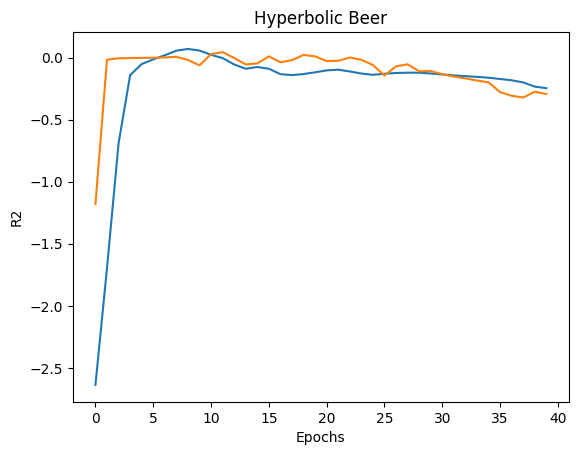

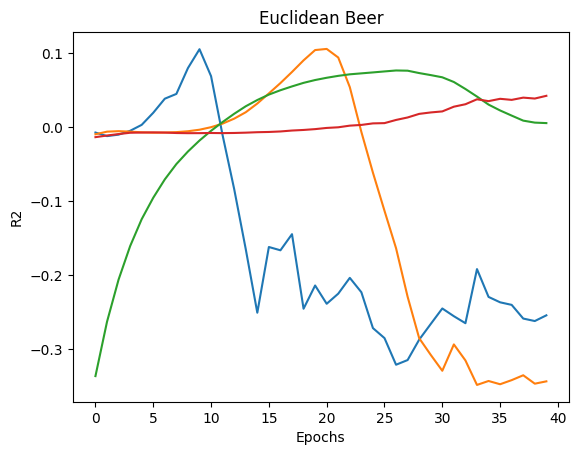

In [15]:
for run in hyp_values.mean(axis=1)[[1459,1345]]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Beer')
plt.ylabel('R2')
plt.xlabel('Epochs')

# plt.ylim(-0.1,0.2)
# plt.yscale('log')
plt.show()

for run in euc_values.mean(axis=1)[[644,952,604,628]]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Beer')
plt.ylabel('R2')
plt.xlabel('Epochs')

# plt.ylim(-0.1,0.2)
# plt.yscale('log')
plt.show()
